In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv

# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape

((455, 30), (114, 30))

### Sucessive halving

In [6]:
gbm = GradientBoostingClassifier(random_state = 42)

In [7]:
param_grid = dict(
    n_estimators = stats.randint(10, 120),
    min_samples_split = stats.uniform(0, 1),
    max_depth = stats.randint(1, 5),
    loss = ('loss', 'exponential')
)

In [8]:
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=3,                  # only a third of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources="smallest",
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
66 fits failed out of a total of 111.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\vish8\anaconda3\Lib\site-packages

HalvingRandomSearchCV(cv=3,
                      estimator=GradientBoostingClassifier(random_state=42),
                      param_distributions={'loss': ('loss', 'exponential'),
                                           'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000294B4468FE0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000294B4469100>,
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000294AEABCCE0>},
                      random_state=10, scoring='roc_auc')

In [9]:
search.best_score_

0.9805029300736262

In [10]:
search.best_params_

{'loss': 'exponential',
 'max_depth': 2,
 'min_samples_split': 0.30545991834281827,
 'n_estimators': 92}

In [11]:
results = pd.DataFrame(search.cv_results_)
results.head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12,0.022098,0.003803,0.002161,0.001074,exponential,2,0.020752,74,...,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
1,0,12,0.026130,0.000855,0.001238,0.000334,exponential,4,0.831911,103,...,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
2,0,12,0.000364,0.000514,0.000000,0.000000,loss,2,0.198063,18,...,NaN,NaN,NaN,NaN,36,NaN,NaN,NaN,NaN,NaN
3,0,12,0.013599,0.000700,0.001047,0.000044,exponential,1,0.263603,46,...,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
4,0,12,0.006430,0.000120,0.001376,0.000437,exponential,1,0.816602,21,...,1.0,1.0,0.944444,0.078567,34,1.0,1.0,1.0,1.0,0.0


In [12]:
results["params_str"] = results.params.apply(str)

results.groupby(["params_str"])["iter"].count().sort_values()

params_str
{'loss': 'loss', 'max_depth': 1, 'min_samples_split': 0.8723924598391091, 'n_estimators': 114}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.09045934927090737, 'n_estimators': 90}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.19806286475962398, 'n_estimators': 18}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.22487280246981334, 'n_estimators': 58}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.33970784363786366, 'n_estimators': 85}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.4563045470947841, 'n_estimators': 118}           1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.523810884938364, 'n_estimators': 40}             1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.6010389534045444, 'n_estimators': 33}            1
{'loss': 'loss', 'max_depth': 2, 'min_samples_split': 0.8211056578369285, 'n_estimators': 21}            1
{'loss': 'loss', 'max_dept

#### The last is the winner

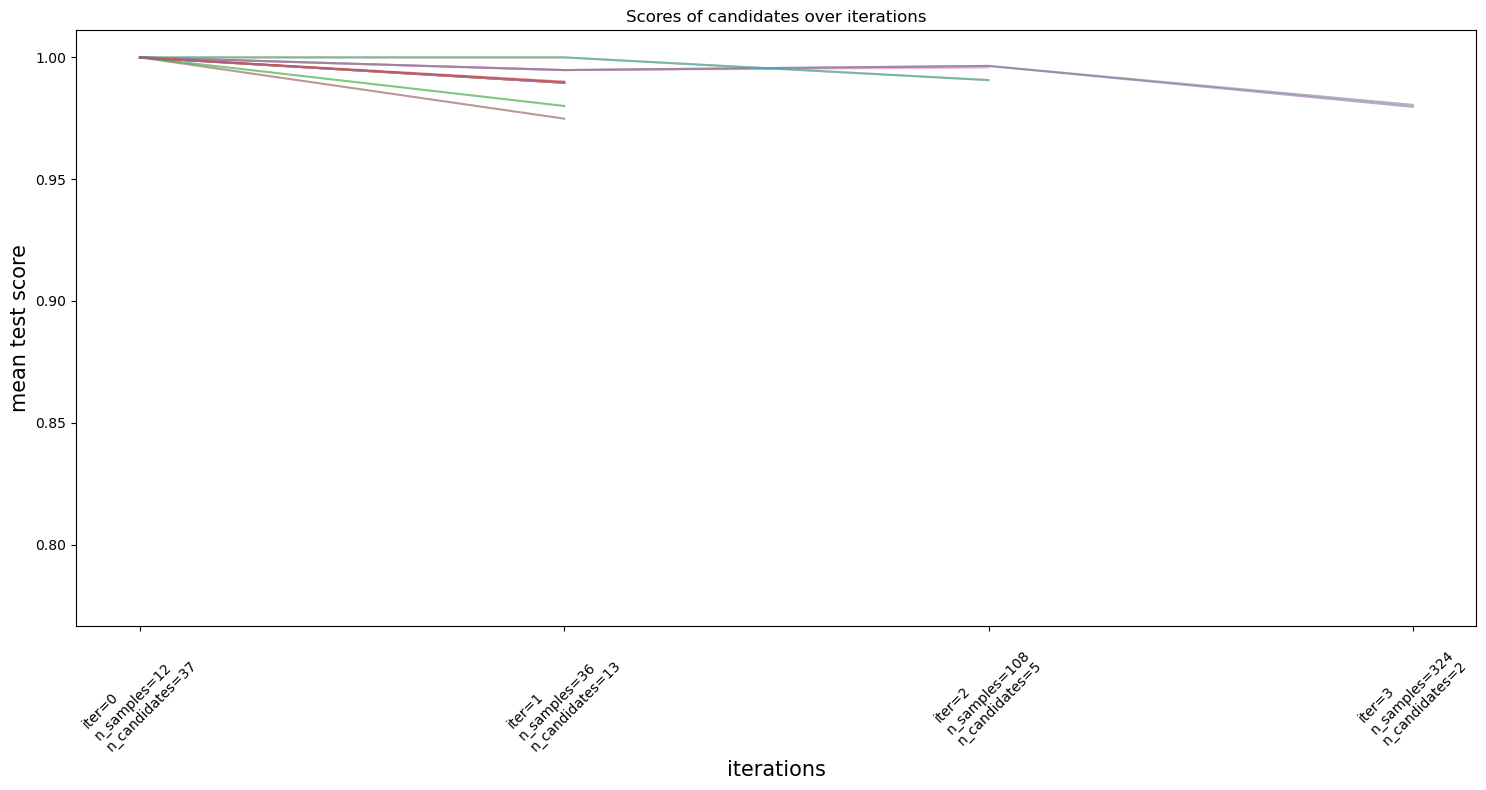

In [13]:
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

# plot
ax = mean_scores.plot(legend=False, alpha=0.6, figsize=(15,8))

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [14]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  1.0
Test roc_auc:  0.9918113331149688


#### Optimizing the search

In [15]:
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources=24,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\vish8\anaconda3\Lib\site-packages\

0.9841948680502898

By reducing the number of minimum resources, usually at the first iteration, we can explore more hyperparameter combinations. Here, we explore 21 combinations using 24 samples as training data.

In [16]:
results = pd.DataFrame(search.cv_results_)
results.groupby("iter")["n_resources"].agg(['mean', "count"])

,mean,count
iter,,
0,24.0,18
1,48.0,9
2,96.0,5
3,192.0,3
4,384.0,2


In [17]:
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources=48,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sk

0.9840673271396163

In [18]:
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources=512,
    min_resources=32,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\vish8\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\vish8\anaconda3\Lib\site-packages\

ValueError: Cannot sample 340 out of arrays with dim 303 when replace is False

In [19]:
results = pd.DataFrame(search.cv_results_)
results.groupby("iter")["n_resources"].agg(['mean', "count"])

AttributeError: 'HalvingRandomSearchCV' object has no attribute 'cv_results_'